In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import uproot #Key library needed to work with ROOT files using numpy/pandas

In [81]:
def generateHeatmap(data):
    """
    DEPRECATED.
    Take in a pandas dataframe containing the data recorded by simulated detectors
    and output a 4x4 matrix containing the muon counts for each detector.
    Depends on pandas and numpy (import before-hand as pd and np respectively).
    
    Args:
    data (Pandas DataFrame): The detector output data.
    
    Returns:
    Numpy array: 4x4 matrix with muon counts (to be plotted on a heatmap).
    
    """
    IDs = data['detectorID']
    emptyArray = [0 for x in range(16)]
    for ID in IDs:
        emptyArray[int(ID%16)] += 1
    emptyArray = np.array(emptyArray)
    emptyArray = np.reshape(emptyArray, (4, 4))
    return(emptyArray)

def tree_to_dataframe(tree_filepath, sort_by = ""):
    """
    Convert a ROOT tree to a Pandas DataFrame (Assuming data is columnar).
    Depends on uproot and pandas libraries (import them before-hand as uproot and pd respectively).
    
    Args:
    tree_filepath (String): The filepath, either absolute or relative, to the ROOT tree data structure.
    sort_by (String), optional: Column of data you want to sort by in ascending order. Default is unsorted.
    
    Returns:
    pandas.DataFrame: The initial columnar tree data as a nice Pandas DataFrame.
    """
    data_all = []
    
    with uproot.open(tree_filepath) as file:
        keys = file.keys()
        for key in keys:
            data_all.append(file[key].array(library="pd"))

    col_names = {i:key for i,key in enumerate(keys)}

    data = pd.DataFrame(data_all).transpose()

    data.rename(columns = col_names, inplace = True)
    
    if sort_by == "":
        return(data)
    else:
        data.sort_values(by=[sort_by], inplace = True)
        data.reset_index(inplace=True, drop=True)
        return(data)
    
def appendData(dataFrames, timeOffset, eventOffset = 2000000000):
    """
    Take in a list of Pandas DataFrames representing the output from individual simulations and construct
    a larger DataFrame complete with time and event offsets to represent one large simulation.
    Depends on Pandas library (import before-hand as pd).
    
    Args:
    dataFrames (list): The list of DataFrames containing information for individual simulations.
    timeOffset (float): The offset in time between each simulation in seconds.
    
    Returns:
    pandas.DataFrame: A large DataFrame combining all output from the simulations to form a large simulation.
    """
    n = len(dataFrames)
    
    for i in range(1, n):
        dataFrames[i]['time'] = (dataFrames[i]['time'])+(i*timeOffset)
        dataFrames[i]['eventID'] = (dataFrames[i]['eventID'])+(i*eventOffset)
    
    bigDF = pd.concat(dataFrames, ignore_index = True)
    
    return(bigDF)

def filterData(data):
    """
    Take in a Pandas DataFrame (presumably the output of appendData function above) containing simulation
    output and return a filtered dataframe that only consists of muons detected in both the 1st and 2nd layers.
    
    Args:
    data (pandas.DataFrame): The total simulation output data.
    
    Returns:
    pandas.DataFrame: The filtered dataframe.
    """
    valueCounts = data['eventID'].value_counts()
    filteredData = data[data['eventID'].isin(valueCounts[valueCounts>1].index)]
    filteredData.reset_index(drop=True, inplace=True)
    filteredData = filteredData.drop_duplicates(subset=['detectorID', 'eventID'], keep = 'first')
    filteredData.reset_index(inplace = True, drop = True)
    valueCounts = filteredData['eventID'].value_counts()
    filteredData = filteredData[filteredData['eventID'].isin(valueCounts[valueCounts>1].index)]
    filteredData.reset_index(drop = True, inplace = True)
    
    return(filteredData)

def zenithAngle(vector):
    """
    Calculate the zenith angle of a vector with respect to the z-axis.
    Depends on numpy (import beforehand as np).
    
    Args:
    vector (array): The vector to calculate the zenith angle of.
    
    Returns:
    float: The zenith angle with respect to the z-axis in radians.
    """
    mag = np.sqrt((vector[0]**2) + (vector[1]**2) + (vector[2]**2))
    newVector = [vector[0]/mag, vector[1]/mag, vector[2]/mag]
    newVector = np.array(newVector)
    
    zVec = [0, 0, -1]
    zVec = np.array(zVec)
    
    dotProd = np.dot(newVector, zVec)
    
    angle = np.arccos(dotProd)
    
    return(angle)

def calculateAngleBins(filteredData):
    """
    Take in your filtered data of simulation output and, for each pair of detections (1st and 2nd layer),
    calculate the zenith angle bin for that muon.
    
    Args:
    filteredData (pandas.DataFrame): The filtered simulation output data.
    
    Returns:
    list: The zenith angle bin values, one for each pair of detections.
    """
    binVals = []
    n = len(filteredData['detectorID'])
    
    pixelArray = np.arange(16).reshape(4,4)
    
    for i in range(0, n, 2):
        angleVector = [0, 0, -76] #cm
        currElem = filteredData['detectorID'][i]%16
        nextElem = filteredData['detectorID'][i+1]%16
        
        currRow, currCol = np.where(pixelArray == currElem)
        nextRow, nextCol = np.where(pixelArray == nextElem)
        
        currX = currCol[0]*2.5
        currY = currRow[0]*-2.5
        nextX = nextCol[0]*2.5
        nextY = nextRow[0]*-2.5
        
        angleVector[0] = nextX-currX
        angleVector[1] = nextY-currY
        
        binVals.append(zenithAngle(angleVector))
    
    return(binVals)

In [59]:
vector = [0, 0, -76]
print(vector)
vector[1] = 10
print(vector)

[0, 0, -76]
[0, 10, -76]


In [40]:
dfs = []
for i in range(4):
    fileName = f"sim/build{i+1}/output0.root:Hits;1"
    dfs.append(tree_to_dataframe(fileName))

In [41]:
#For this experiment, looking at terminal output for time of arrival of muons, offset per percentage is about
#255.246 seconds --> Offset per run is about 25,524.6 seconds
data = appendData(dfs, timeOffset = 25524.6)
data

,detectorID,time,eventID
0,15.0,1072.491164,5.779740e+07
1,20.0,1417.646420,8.452237e+07
2,15.0,3862.345872,2.764163e+08
3,22.0,3864.890191,2.764163e+08
4,31.0,4128.389077,2.967939e+08
...,...,...,...
134,12.0,100297.431120,7.832509e+09
135,19.0,100299.969490,7.832509e+09
136,12.0,100382.317258,7.839156e+09
137,8.0,101932.900386,7.960854e+09


In [42]:
valueCounts = data['eventID'].value_counts()
filteredData = data[data['eventID'].isin(valueCounts[valueCounts>1].index)]

In [44]:
filteredData.reset_index(drop=True, inplace=True)

In [45]:
filteredData

,detectorID,time,eventID
0,15.0,3862.345872,2.764163e+08
1,22.0,3864.890191,2.764163e+08
2,21.0,4397.538496,3.179672e+08
3,22.0,4397.559704,3.179672e+08
4,0.0,5480.927453,4.033185e+08
5,24.0,5483.464303,4.033185e+08
6,0.0,9115.612189,6.880192e+08
7,0.0,9115.634821,6.880192e+08
8,19.0,9118.160674,6.880192e+08
9,9.0,11033.343152,8.383187e+08


In [46]:
filteredData2 = filteredData.drop_duplicates(subset=['detectorID', 'eventID'], keep = 'first')

In [48]:
filteredData2.reset_index(inplace = True, drop = True)

In [49]:
filteredData2

,detectorID,time,eventID
0,15.0,3862.345872,2.764163e+08
1,22.0,3864.890191,2.764163e+08
2,21.0,4397.538496,3.179672e+08
3,22.0,4397.559704,3.179672e+08
4,0.0,5480.927453,4.033185e+08
5,24.0,5483.464303,4.033185e+08
6,0.0,9115.612189,6.880192e+08
7,19.0,9118.160674,6.880192e+08
8,9.0,11033.343152,8.383187e+08
9,16.0,11035.887020,8.383187e+08


In [50]:
valueCounts = filteredData2['eventID'].value_counts()
filteredData3 = filteredData2[filteredData2['eventID'].isin(valueCounts[valueCounts>1].index)]

In [51]:
filteredData3

,detectorID,time,eventID
0,15.0,3862.345872,2.764163e+08
1,22.0,3864.890191,2.764163e+08
2,21.0,4397.538496,3.179672e+08
3,22.0,4397.559704,3.179672e+08
4,0.0,5480.927453,4.033185e+08
5,24.0,5483.464303,4.033185e+08
6,0.0,9115.612189,6.880192e+08
7,19.0,9118.160674,6.880192e+08
8,9.0,11033.343152,8.383187e+08
9,16.0,11035.887020,8.383187e+08


In [63]:
filterData(data)

,detectorID,time,eventID
0,15.0,3862.345872,2.764163e+08
1,22.0,3864.890191,2.764163e+08
2,21.0,4397.538496,3.179672e+08
3,22.0,4397.559704,3.179672e+08
4,0.0,5480.927453,4.033185e+08
5,24.0,5483.464303,4.033185e+08
6,0.0,9115.612189,6.880192e+08
7,19.0,9118.160674,6.880192e+08
8,9.0,11033.343152,8.383187e+08
9,16.0,11035.887020,8.383187e+08


In [72]:
calculateAngleBins(filterData(data))

[0.07342264488147608,
 0.032882879805509725,
 0.06569480155246345,
 0.09836572163236873,
 0.07342264488147608,
 0.032882879805509725,
 0.07342264488147608,
 0.09836572163236873,
 0.032882879805509725,
 0.07342264488147608,
 0.06569480155246345,
 0.0,
 0.032882879805509725,
 0.13866491208556878]

### Seeing how many unique zenith angle bins there are.

In [79]:
testIDPairs = [(x, y) for x in range(16) for y in range(16, 32)]
testIDList = []
for x in testIDPairs:
    testIDList.append(x[0])
    testIDList.append(x[1])
testData = pd.DataFrame(testIDList, columns=['detectorID'])
testData

,detectorID
0,0
1,16
2,0
3,17
4,0
...,...
507,29
508,15
509,30
510,15


In [83]:
allPossibleAngleBins = calculateAngleBins(testData)
allPossibleAngleBins

[0.0,
 0.032882879805509725,
 0.06569480155246345,
 0.09836572163236873,
 0.032882879805509725,
 0.04648666794594151,
 0.07342264488147608,
 0.1036495128747235,
 0.06569480155246345,
 0.07342264488147608,
 0.09277328350368548,
 0.11805218170742375,
 0.09836572163236873,
 0.1036495128747235,
 0.11805218170742375,
 0.13866491208556878,
 0.032882879805509725,
 0.0,
 0.032882879805509725,
 0.06569480155246345,
 0.04648666794594151,
 0.032882879805509725,
 0.04648666794594151,
 0.07342264488147608,
 0.07342264488147608,
 0.06569480155246345,
 0.07342264488147608,
 0.09277328350368548,
 0.1036495128747235,
 0.09836572163236873,
 0.1036495128747235,
 0.11805218170742375,
 0.06569480155246345,
 0.032882879805509725,
 0.0,
 0.032882879805509725,
 0.07342264488147608,
 0.04648666794594151,
 0.032882879805509725,
 0.04648666794594151,
 0.09277328350368548,
 0.07342264488147608,
 0.06569480155246345,
 0.07342264488147608,
 0.11805218170742375,
 0.1036495128747235,
 0.09836572163236873,
 0.10364951

In [84]:
len(set(allPossibleAngleBins))

10

In [85]:
max(allPossibleAngleBins)

0.13866491208556878

<Axes: >

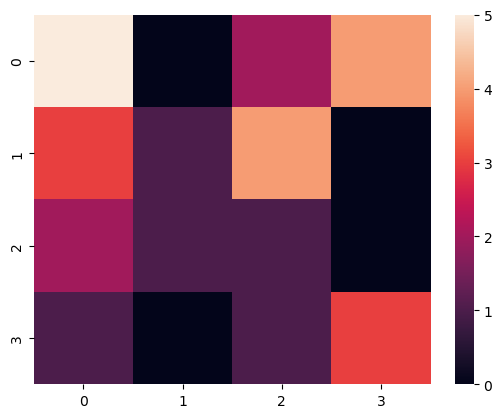

In [87]:
sns.heatmap(generateHeatmap(filterData(data)))

In [89]:
np.arange(16, 32).reshape(4,4)

array([[16, 17, 18, 19],
       [20, 21, 22, 23],
       [24, 25, 26, 27],
       [28, 29, 30, 31]])